In [1]:
# Import the flopy library
import flopy
# Import a few additional libraries
import sys
import os

import gstools as gs
from pykrige.ok import OrdinaryKriging
# In addition to our typical libraries
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from copy import deepcopy as deepcopy

In [2]:
# Path to MODFLOW executable, probably called 'mf2005'
exe_name_mf = 'C:\\Users\\willg\\Hydro_programs\\MF2005.1_12\\bin\\mf2005'
# Print to make sure it is formated correctly
print(exe_name_mf)
# Path to MT3D-USGS executable, probably called 'mt3dms'
exe_name_mt = 'C:\\Users\\willg\\Hydro_programs\\mt3dusgs1.1.0\\bin\\mt3d-usgs_1.1.0_64'
# Print to make sure it is formated correctly
print(exe_name_mt)

C:\Users\willg\Hydro_programs\MF2005.1_12\bin\mf2005
C:\Users\willg\Hydro_programs\mt3dusgs1.1.0\bin\mt3d-usgs_1.1.0_64


In [3]:
# This should return a path to your current working directory
current_directory = os.getcwd()
print(current_directory)

C:\Users\willg\OneDrive\Documents\2_School\GraduateSchool\Fall2021\!Research\Geostatistics_paper


In [4]:
# if this is not where you want to save stuff then change your directory using 'os.chdir()'
os.chdir('C:\\Users\\willg\\Documents\\GitHub\\Contaminant-Hydrogeology-Activities\\TestModels') # laptop
# os.chdir('D:\\Dropbox\\Teaching\\Contaminant hydro 629\\Modeling_excercises') # desktop
current_directory = os.getcwd()
print(current_directory)

C:\Users\willg\Documents\GitHub\Contaminant-Hydrogeology-Activities\TestModels


In [5]:
# directory to save data
directory_name = 'PFAS_test'
# directory to save data
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')
workdir = os.path.join('.', directory_name)

In [6]:
def plot_2d(map_data, dx, dy, colorbar_label, title, cmap):
    # shape information
    r, c = np.shape(map_data)
    # define plot coordinates
    x_coord = np.linspace(0, dx*c, c+1)
    y_coord = np.linspace(0, dy*r, r+1)
    
    X, Y = np.meshgrid(x_coord, y_coord)

    plt.figure(figsize=(8, 4), dpi=120)
    plt.pcolormesh(X, Y, map_data, cmap=cmap, shading = 'auto', edgecolor ='k', linewidth = 0.05)
    plt.gca().set_aspect('auto')  #changed from equal
    # add a colorbar
    cbar = plt.colorbar() 
    # plt.clim(cmin, cmax) 
    # label the colorbar
    cbar.set_label(colorbar_label)
    plt.tick_params(axis='both', which='major')
    plt.xlim((0, dx*c)) 
    plt.ylim((0, dy*r)) 
    plt.title(title)
    plt.show()

### Geostatistics

In [7]:
def perm_field_generation(log_mD, log_var, correlat_len, ycorrelat_len, nlay, nrow, ncol, angle):
    x = np.arange(nlay)
    y = np.arange(nrow)
    z = np.arange(ncol)

    model = gs.Exponential(dim=3, var=10**log_var, len_scale=[1.0, ycorrelat_len, correlat_len], angles=[0.0, 0.0, angle])
    
    # If you specify the same seed then the generator will produce the same realization over and over
    # srf = gs.SRF(model, seed=25300)
    srf = gs.SRF(model)
    
    field = 10**(srf.structured([x, y, z]) + log_mD)
    
    print('Geometric mean: ' + str(np.log10(np.max(field)/np.min(field))) + ' mD')
    
    # convert from mD to km^2
    field_km2 = field*(9.869233E-13/1000)
    return field_km2

In [8]:
def coarsen_geomean(array2d, coarseness):
    array_size = array2d.shape
    # calculate if array is evenly divisible by level of coarsening
    rem0 = array_size[0] % coarseness
    rem1 = array_size[1] % coarseness
    if rem0 + rem1 > 0:
        raise NameError('array is not divisible by coarseness factor')
    
    # preallocate new array of values
    coarse_array = np.zeros([int(array_size[0]/coarseness), int(array_size[1]/coarseness)])
    n = coarseness**2
    # set row index
    rind = 0
    for i in range(0, array_size[0], coarseness):
        # reset column index
        cind = 0
        for j in range(0, array_size[1], coarseness):
            # calculation geometric mean of some group of grid cells
            geo_mean_cell = np.exp(np.sum(np.log(array2d[i:i+coarseness, j:j+coarseness]))/n)
            coarse_array[rind, cind] = geo_mean_cell
            # update column index
            cind += 1
        # update row index
        rind +=1
    
    # return the coarsened data
    return coarse_array

### Model

In [9]:
def model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, spd_mf, spd_mt, nlay, nrow, ncol, hk):
#                      dirname, perlen_mf, al, ibound, strt, icbund, sconc, spd_mf, spd_mt, nlay, nrow, ncol
    # Model workspace and new sub-directory
    model_ws = os.path.join(workdir, dirname)
    print(model_ws)
    
    # time units (itmuni in discretization package), unfortunately this entered differently into MODFLOW and MT3D
    # 1 = seconds, 2 = minutes, 3 = hours, 4 = days, 5 = years
    itmuni = 4 # MODFLOW
    mt_tunit = 'D' # MT3D units
    # length units (lenuniint in discretization package)
    # 0 = undefined, 1 = feet, 2 = meters, 3 = centimeters
    lenuni = 2 # MODFLOW units
    mt_lunit = 'M' # MT3D units
    
    # number of stress periods (MF input), calculated from period length input
    nper = len(perlen_mf)
    
    # Frequency of output, If nprs > 0 results will be saved at 
    #     the times as specified in timprs; 
    nprs = 100
    # timprs (list of float): The total elapsed time at which the simulation 
    #     results are saved. The number of entries in timprs must equal nprs. (default is None).
    timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)
    
    # hydraulic conductivity
#     k1 = 1  # m/d
#     k2 = 0.5  # m/d
#     hk = k1 * np.ones((nlay, nrow, ncol), dtype=float)
#     hk[2:4, :, :] = k2
#     hk[2:4, :, :] = k2
#     hk = hk_test # permeability field
    # porosity
    prsity = 0.42
    
    # Grid cell size in selected units
    coarsen_fact = 1
    delv = 0.2 * coarsen_fact # grid size for nlay
    delc = 5 * coarsen_fact # grid size for nrow
    delr = 5 * coarsen_fact # grid size for ncol

    # Setup models
    # MODFLOW model name
    modelname_mf = dirname + '_mf'
    # Assign name and create modflow model object
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    # MODFLOW model discretization package class
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper,
                                   delr=delr, delc=delc, top=0., botm=[-delv * k for k in range(1, nlay + 1)],
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    # MODFLOW basic package class
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    # MODFLOW layer properties flow package class
    laytyp = 0
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    # MODFLOW well package class
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=spd_mf)
    # MODFLOW preconditioned conjugate-gradient package class
    pcg = flopy.modflow.ModflowPcg(mf)
    # MODFLOW Link-MT3DMS Package Class (this is the package for solute transport)
    lmt = flopy.modflow.ModflowLmt(mf)
    
    mf.write_input()
    mf.run_model(silent=True) # Set this to false to produce output in command window
    
    # RUN MT3dms solute tranport 
    modelname_mt = dirname + '_mt'
    # MT3DMS model object
    # Input: modelname = 'string', namefile_ext = 'string' (Extension for the namefile (the default is 'nam'))
    # modflowmodelflopy.modflow.mf.Modflow = This is a flopy Modflow model object upon which this Mt3dms model is based. (the default is None)
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)  
    
    
    # Basic transport package class
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, 
                             tunit=mt_tunit, lunit=mt_lunit, nprs=nprs, timprs=timprs)
    
    # Advection package class
    # mixelm is an integer flag for the advection solution option, 
    # mixelm = 0 is the standard finite difference method with upstream or central in space weighting.
    # mixelm = 1 is the forward tracking method of characteristics, this produces minimal numerical dispersion.
    # mixelm = 2 is the backward tracking
    # mixelm = 3 is the hybrid method (HMOC)
    # mixelm = -1 is the third-ord TVD scheme (ULTIMATE)
    mixelm = -1
    # percel is the Courant number for numerical stability (≤ 1)
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, percel=0.5)
    
    # Dispersion package class
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
    
    # reaction module parameters
    # isothm = 0, no sorption is simulated; isothm = 1, 
    # linear isotherm (equilibrium-controlled); isothm = 2, 
    # Freundlich isotherm (equilibrium-controlled); isothm = 3, 
    # Langmuir isotherm (equilibrium-controlled).
    isothm = 3
    rhob = 1.52
    #for PFOS...
    kd = 0.34 #note will need to add the effect of carbon...
    N = 0.7
    
    # ireact is an integer flag indicating which type of kinetic rate reaction is simulated: ireact = 0, no kinetic rate reaction is simulated
    # rc1 is the first-order reaction rate for the dissolved (liquid) phase for the first species (unit, T-1). rc1 is not used ireact = 0.
    # rc2 is the first-order reaction rate for the sorbed phase for the first species (unit, T-1). rc2 is not used ireact = 0. 
    
    # Reactions package class
    rct = flopy.mt3d.Mt3dRct(mt, isothm=isothm, ireact=0, igetsc=0,
                             rhob=rhob, sp1=kd, sp2 = N)
    
    # source/sink package
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd_mt)
    # matrix solver package, may want to add cclose=1e-6 to define the convergence criterion in terms of relative concentration
    gcg = flopy.mt3d.Mt3dGcg(mt, cclose=1e-6)
    # write mt3dms input
    mt.write_input()
    
    # run mt3dms
    mt.run_model(silent=True)

    # Extract output
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    # Extract the output time information, convert from list to np array
    times = np.array(ucnobj.get_times())
    # Extract the 4D concentration values (t, z, y, x)
    conc = ucnobj.get_alldata()
    
    return mf, mt, times, conc

### Import head file 

(60, 110)


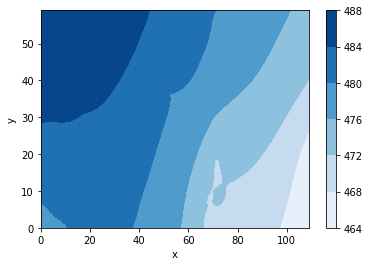

In [10]:
#import head values from Elliot's model
#note headfile c1 = row, c2 = column, c3 = head values, c4 = layer
head_file = 'C:\\Users\\willg\\OneDrive\\Documents\\2_School\\GraduateSchool\\Fall2021\\!Research\\Geostatistics_paper\\head_norm_v1.csv' 
head_vals = genfromtxt(head_file, delimiter=',')
#print(head_vals)

#creating the 2d grid of head values
#https://stackoverflow.com/questions/38749140/how-to-make-a-matrix-out-of-existing-xyz-data
x_head = np.unique(head_vals[:,0]) #rows
# print(x)
y_head = np.unique(head_vals[:,1]) #cols
# print(y)
X, Y = np.meshgrid(x_head,y_head)

def get_z(mat, x_head, y_head):
    ind = (mat[:,(0,1)] == (x_head,y_head)).all(axis=1)
    row = mat[ind,:]
    return row[0,2]

z = np.array([get_z(head_vals,x_head,y_head) for (x_head,y_head) in zip(np.ravel(X), np.ravel(Y))])

#array of head values
head_values = z.reshape(X.shape)

#visualize
plt.contourf(X, Y, head_values, levels = 6, cmap = 'Blues')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
# plt.gca().invert_xaxis()

#model size and permeability field creation
mod_size = head_values.shape
print(mod_size)

In [20]:
coarse_factor = 2 #or 5
head_values_coarse = coarsen_geomean(head_values, coarse_factor)
mod_size = head_values_coarse.shape
print(mod_size)

(30, 55)


### Define stress periods
Stress period definition: for this model there will be two stress periods. One with no pumping and one with pumping

In [21]:
# perlen (float or array of floats): An array of the stress period lengths.
perlen_mf = [5*365, 10*365, 2*365] #5 years of input, 10 years of pumping, 2 yeras of no pumping
nper = len(perlen_mf)

print(len(perlen_mf))

3


### Define model geometry

In [22]:
# Number of grid cells -- start 2D
nlay = 10
nrow = mod_size[0]
ncol = mod_size[1]

x = np.arange(nlay)
y = np.arange(nrow)
z = np.arange(ncol)

### Heterogeneous Realizations

In [23]:
#creating the base model
log_mD = 15
log_var = 1.3
correlat_len = 60
ycorrelat_len = 10
angle = np.pi / 1

# break apart this funtion to return the model for kriging
hk_test = perm_field_generation(log_mD, log_var, correlat_len, ycorrelat_len, nlay, nrow, ncol, angle)
# plot_2d(hk_test[4,:,:], 1, 1, '[m/day]', 'viridis')

model = gs.Exponential(dim=3, var=10**log_var, len_scale=[10, ycorrelat_len, correlat_len], angles=[0.0, 0.0, angle])



Geometric mean: 25.655273128282317 mD


### Conditioning the random field

In [24]:
#conditioning - three well locations constraining locations of fine and coarse material
#as it relates to hydraulic conductivity (fine on top, coarse towards the bottom)
             #nlay, nrow, ncol
cond_pos = [[9.0, 5.0, 1.0, 4.0, 1.0, 8.0, 4.0, 1.0],
            [26, 30, 34, 35, 26, 30, 34, 35],
            [84, 58, 28, 27, 84, 58, 28, 27]]

cond_val =  [10.454, 12.442, 1.058, 14.602, 14.602, 2.906, 24.97, 18.166]

#krige the model with data points
krige = gs.Krige(model, cond_pos=cond_pos, cond_val=cond_val)

In [25]:
cond_srf = gs.CondSRF(krige, seed = 15)
field_km2_cond = (cond_srf.structured([x, y, z]))

# field_cond = (10**(cond_srf.structured([x, y, z]) + log_mD))
# field_km2_cond = field_cond*(9.869233E-13/1000)

In [26]:
cond_srf1 = gs.CondSRF(krige, seed = 40)
field_km2_cond1 = (cond_srf1.structured([x, y, z]))
# field_cond1 = (10**(cond_srf1.structured([x, y, z]) + log_mD))
# field_km2_cond1 = field_cond1*(9.869233E-13/1000)

In [27]:
cond_srf2 = gs.CondSRF(krige, seed = 5489)
field_km2_cond2 = (cond_srf2.structured([x, y, z]))
# field_cond2 = (10**(cond_srf2.structured([x, y, z]) + log_mD))
# field_km2_cond2 = field_cond2*(9.869233E-13/1000)

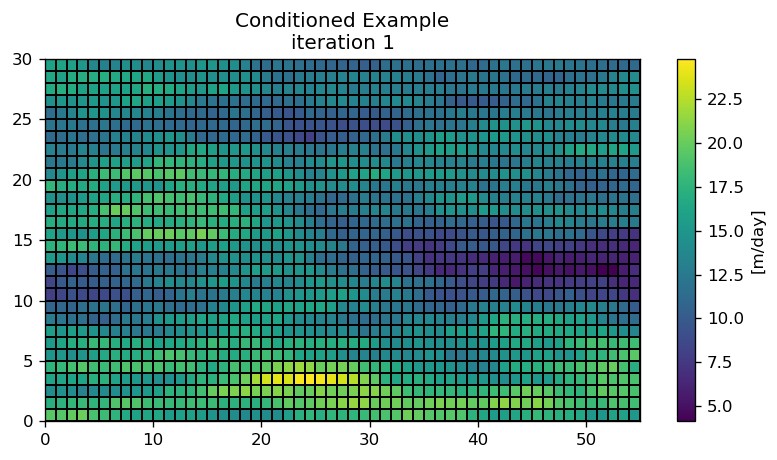

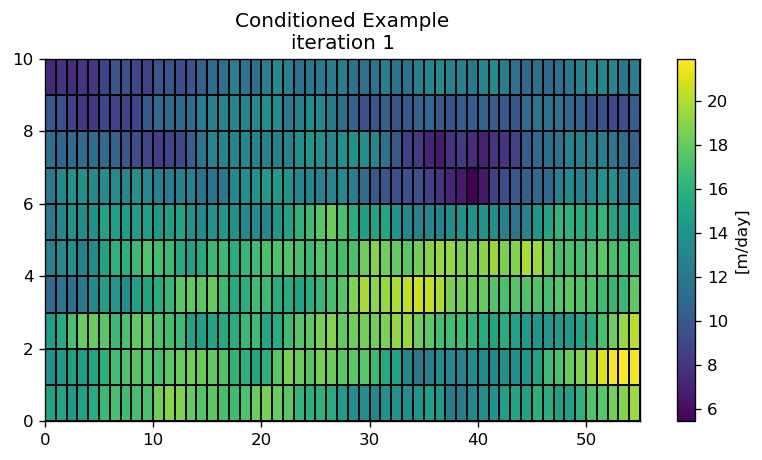

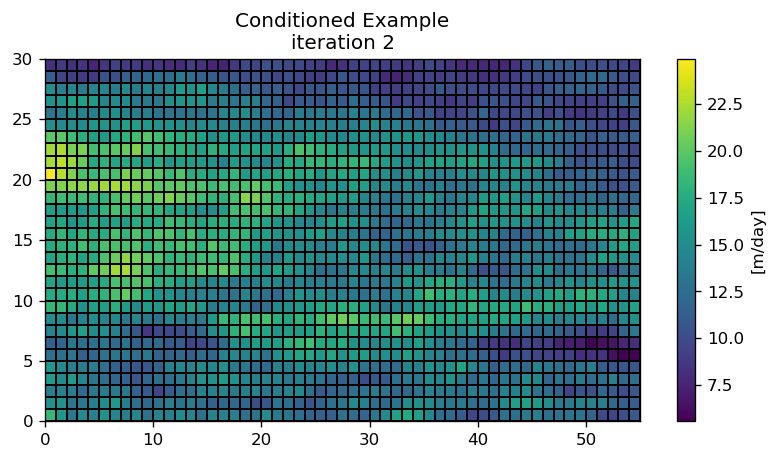

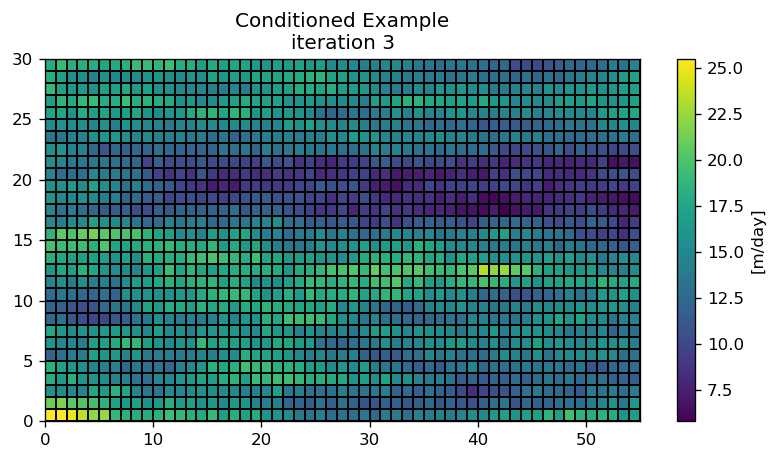

In [28]:
#view along the x-z plane
plot_2d(field_km2_cond[0,:,:], 1, 1, '[m/day]','Conditioned Example\niteration 1', 'viridis')
# plot_2d(field_km2_cond[:,5,:], 1, 1, '[m/day]','Conditioned Example\niteration 1', 'viridis')
plot_2d(field_km2_cond1[0,:,:], 1, 1, '[m/day]','Conditioned Example\niteration 2', 'viridis')
plot_2d(field_km2_cond2[0,:,:], 1, 1, '[m/day]','Conditioned Example\niteration 3', 'viridis')

### Conditioned organic carbon content

### Homogeneous Field

In [ ]:
#Homogeneous comparison
homog = np.full((nlay, nrow, ncol), 20) #make this the geometric mean

### Define flow boundary conditions

In [41]:
# boundary conditions, <0 = specified head, 0 = no flow, >0 variable head
ibound = np.ones((nlay, nrow, ncol), dtype=int)

#bottom layer (layer -1) = no flow #leave this one commented
# ibound[-1,:,:] = 0               #leave this commented

#bounding head box
#upper = specified head
# ibound[:,-1,:] = -1

#lower = specified head
# ibound[:,0,:] = -1

#right
ibound[:,:,-1] = -1

#left
# ibound[:,:,0] = -1

(10, 30, 55)
(30, 55)


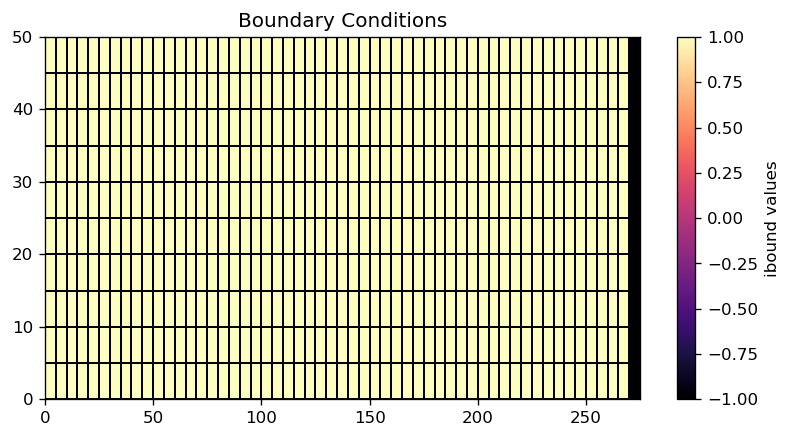

In [42]:
print(ibound.shape)
print(ibound[0,:,:].shape)

plot_2d(ibound[:,1,:], 5, 5, 'ibound values', 'Boundary Conditions','magma') #layer one

### Head conditions

In [43]:
# Now flow initial conditions. All cells where ibound=1 will be solved in the flow model.
# constant head conditions

strt = np.zeros((nlay, nrow, ncol), dtype=float)

#this is where the issues begin

# for k in range(nlay):
#     strt[k] = head_values_coarse

# plot_2d(strt[5,:,:], 5, 5, 'meters of head', 'head profile', 'Blues')


#=======testing different head conditions===========================================
# x = np.arange(nlay)
# y = np.arange(nrow)
# z = np.arange(ncol)

# model = gs.Gaussian(dim=3, var=0.1, len_scale=20)
# srf = gs.SRF(model)
# strt_test = 10**srf.structured([x, y, z]) #meters?
# plot_2d(strt_test[0,:,:], 1, 1, 'meters', 'Blues')

### Define Flow Wells

In [44]:
# total flow 
q = [0.5, 0.5, 0.5] # corresponding to each stress period

# Stress period well data for MODFLOW. Each well is defined through defintition
# of layer (int), row (int), column (int), flux (float). The first number corresponds to the stress period
# Example for 1 stress period: spd_mf = {0:[[0, 0, 1, q],[0, 5, 1, q]]}
# define well info structure
well_info = np.zeros((int(nrow), 4), dtype=float) #nrow -- original
# set indices of left face of model
well_info[:,1] = range(0, nrow) #nrow -- original
# set volumetric flow rate
well_info[:,3] = q[0]
w = deepcopy(well_info)
spd_mf={0:w}

#explicetly defining stress periods for layer (above), row, and col, each with the same q
well_info[:,3] = q[1]
# use copy.deepcopy (imported as 'deepcopy') to copy well_info array into dictonary
# note that if this deepcopy isn't made then when the flow rate it updated
# in well_info it will update all values copied to dictionary!
w = deepcopy(well_info)
# Now insert well information into the MODFLOW stress period data dictionary
spd_mf.update({1:w})

well_info[:,3] = q[2]
# use copy.deepcopy (imported as 'deepcopy') to copy well_info array into dictonary
# note that if this deepcopy isn't made then when the flow rate it updated
# in well_info it will update all values copied to dictionary!
w = deepcopy(well_info)
# Now insert well information into the MODFLOW stress period data dictionary
spd_mf.update({2:w})


#testing wells
q0 = 10

#may need to be changed depending on the coarsen factor
welspd_test = {0: [[0, 10, 1, q0]], 1: [[0, 10, 1, q0]], 2: [[0, 10, 1, 0]]}
# welspd_test = {0: [[0, , 23, -q0]], 1: [[0, 2, 23, -q0]], 2: [[0, 2, 23, 0]]}

# obs = [2, 2, 23]

### Define transport boundary conditions and intitial conditions

In [45]:
# Boundary conditions: if icbund = 0, the cell is an inactive concentration cell; 
# If icbund < 0, the cell is a constant-concentration cell; 
# If icbund > 0, the cell is an active concentration cell where the concentration value will be calculated.
icbund = np.ones((nlay, nrow, ncol), dtype=int)

# Initial conditions: initial concentration zero everywhere
sconc = np.zeros((nlay, nrow, ncol), dtype=float)


### Define solute conditions at wells for different stress periods

In [46]:
# Solute transport boundary conditions
# Concentration at well during first stress period
c = [1, 0, 0] #[1,0,0]

#MT3D stress period data, note that the indices between 'spd_mt' must exist in 'spd_mf' 
#This is used as input for the source and sink mixing package
#Itype is an integer indicating the type of point source, 2=well, 3=drain, -1=constant concentration
itype = -1
cwell_info = np.zeros((int(nrow), 5), dtype=float)
cwell_info[:,1] = range(0, nrow)
cwell_info[:,3] = c[0]
# assign itype
cwell_info[:,4] = itype
spd_mt = {0:cwell_info}

# Second stress period        
cwell_info2 = deepcopy(cwell_info)
cwell_info2[:,3] = c[1] 
# Now apply stress period info    
spd_mt.update({1:cwell_info2})

# Third stress period        
cwell_info2 = deepcopy(cwell_info)
cwell_info2[:,3] = c[2] 
# Now apply stress period info 
spd_mt.update({2:cwell_info2})

# print(spd_mt)
c0 = 1
spd_test = {0: [0, 10, 1, c0, -1], 1: [0, 10, 1, 0.0, -1], 2: [0, 10, 1, 0.0, -1]}

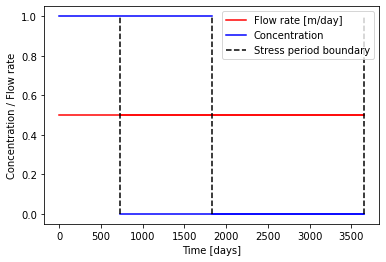

In [47]:
plt.plot([0, perlen_mf[0]], [q[0], q[0]], color='r', label= 'Flow rate [m/day]')
plt.plot([perlen_mf[0], perlen_mf[1]], [q[1], q[1]], color='r')
plt.plot([perlen_mf[1], perlen_mf[2]], [q[2], q[2]], color='r')

plt.plot([0, perlen_mf[0]], [c[0], c[0]], color='b', label= 'Concentration')
plt.plot([perlen_mf[0], perlen_mf[1]], [c[1], c[1]], color='b')
plt.plot([perlen_mf[1], perlen_mf[2]], [c[2], c[2]], color='b')

plt.plot([perlen_mf[0], perlen_mf[0]], [min(c), max(c)], '--k', label= 'Stress period boundary')
plt.plot([perlen_mf[1], perlen_mf[1]], [min(c), max(c)], '--k', )
plt.plot([perlen_mf[2], perlen_mf[2]], [min(c), max(c)], '--k', )

plt.xlabel('Time [days]')
plt.ylabel('Concentration / Flow rate')
plt.legend()

### Run model

In [48]:
#undefined stress periods

dirname = 'run2'
al = 0.8 # m

# Call the FloPy model function with this well information - continuous injections
mf, mt, times, conc = model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, 
                                       spd_mf, spd_mt, nlay, nrow, ncol, field_km2_cond)

# To understand output size it may be useful to print the shape
print(conc.shape)
grid = mf.modelgrid

.\PFAS_test\run2
(103, 10, 30, 55)


In [52]:
#testing point locations (defined stress periods at locations)
dirname = 'run9'
al = 0.8 # m

# Call the FloPy model function with this well information - point source input...
mf, mt, times, conc = model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, 
                                       welspd_test, spd_test, nlay, nrow, ncol, field_km2_cond)

# To understand output size it may be useful to print the shape
print(conc.shape)
grid = mf.modelgrid

.\PFAS_test\run9
(103, 10, 30, 55)


### Plotting Results  - Heterogeneous fields

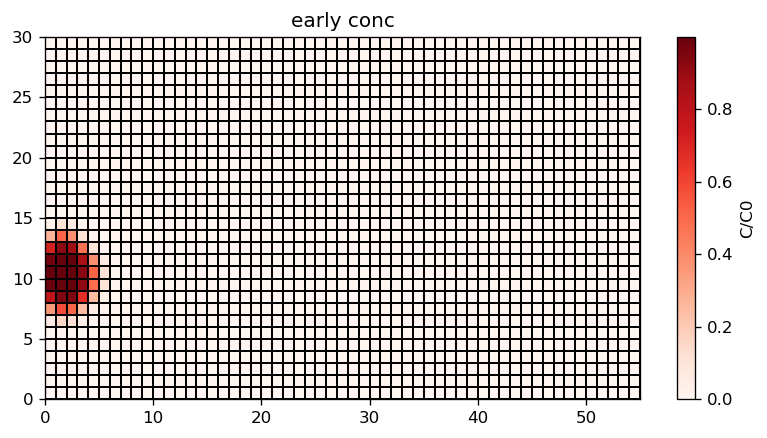

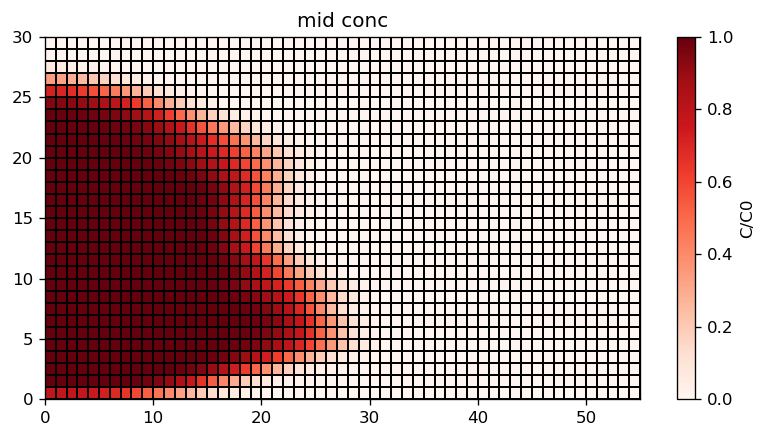

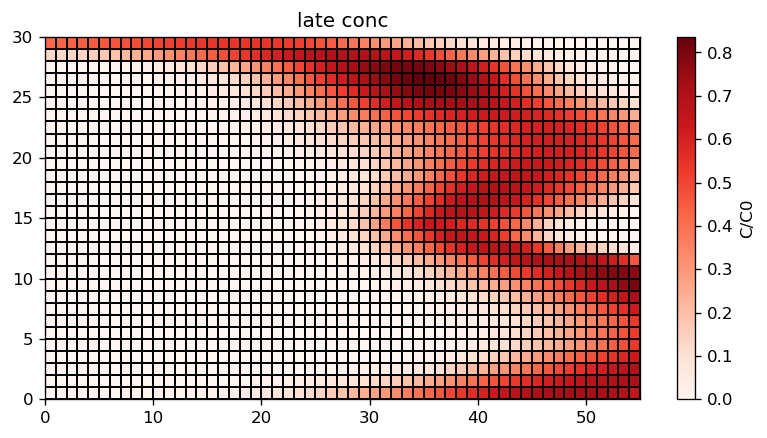

In [53]:
# early time
layer = 2
# plot_2d(field_km2_cond[layer,:,:], 1, 1, '[m/day]','Conditioned Example\niteration 1', 'viridis')
plot_2d(conc[1,layer,:,:]/c0, 1, 1, 'C/C0', 'early conc', 'Reds') #time, layer, row, col
# plot_2d(conc[1,:,6,:]/c0, 1, 1, 'C/C0', 'early conc', 'Reds') #time, layer, row, col

# last time step
plot_2d(conc[25,layer,:,:]/c0, 1, 1, 'C/C0', 'mid conc', 'Reds')
# plot_2d(conc[25,:,6,:]/c0, 1, 1, 'C/C0', 'mid conc', 'Reds')

# last time step
plot_2d(conc[-1,layer,:,:]/c0, 1, 1, 'C/C0', 'late conc', 'Reds')

C:\Users\willg\anaconda3\envs\GWmodel_v1\lib\site-packages\flopy\modflow\mfdis.py:298: DeprecationWarning: SpatialReference has been deprecated. Use Grid instead.
  warnings.warn(


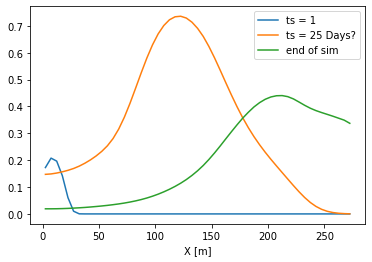

In [57]:
# Extract the model grid cell center location (in selected units, cm in this case)
x = mf.dis.sr.xcenter
plt.plot(x, np.mean(conc[1, layer, :, :], axis=0), label='ts = 1')
plt.plot(x, np.mean(conc[50, layer, :, :], axis=0), label='ts = 50')
plt.plot(x, np.mean(conc[-1, layer, :, :], axis=0), label='end of sim')
plt.xlabel('X [m]');
# plt.ylim(0,0.4)
plt.legend()


<a list of 5 text.Text objects>

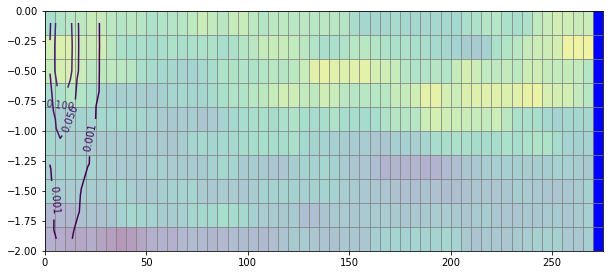

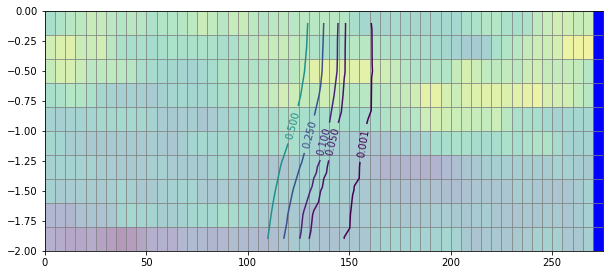

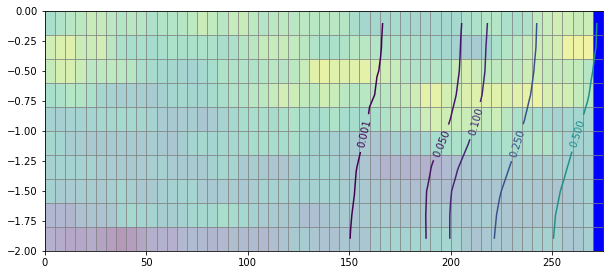

In [55]:
#contour plots, vertical view thru rows
fig = plt.figure(figsize=(10, 15))
hk = mf.lpf.hk.array

lev_test = [0.001, 0.05, 0.1, 0.25, 0.5, 1]
row_lay = 6

ax = fig.add_subplot(3, 1, 1)
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": row_lay})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.4)
mx.plot_ibound()
mx.plot_grid(color="0.5", alpha=0.5)
cs = mx.contour_array(
    conc[1], levels=lev_test
)
plt.clabel(cs)

fig = plt.figure(figsize=(10, 15))
hk = mf.lpf.hk.array

ax = fig.add_subplot(3, 1, 1)
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": row_lay})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.4)
mx.plot_ibound()
mx.plot_grid(color="0.5", alpha=0.5)
cs = mx.contour_array(
    conc[25], levels=lev_test,
)
plt.clabel(cs)

fig = plt.figure(figsize=(10, 15))
hk = mf.lpf.hk.array

ax = fig.add_subplot(3, 1, 1)
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": row_lay})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.4)
mx.plot_ibound()
mx.plot_grid(color="0.5", alpha=0.5)
cs = mx.contour_array(
    conc[-1], levels=lev_test
)
plt.clabel(cs)

### Homogeneous fields

In [ ]:
#testing point location sources and defined head -- homogeneous field
dirname = 'run12'
al = 0.8 # m

# Call the FloPy model function with this well information
mf_homog, mt_homog, times_homog, conc_homog = model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, 
                                                               welspd_test, spd_test, nlay, nrow, ncol, homog)

# To understand output size it may be useful to print the shape
print(conc.shape)
grid = mf.modelgrid

In [ ]:
#homogeneous test
layer = 0

plot_2d(conc_homog[1,layer,:,:]/c0, 1, 1, 'C/C0', 'Reds') #time, layer, row, col

# last time step
plot_2d(conc_homog[25,layer,:,:]/c0, 1, 1, 'C/C0', 'Reds')

# last time step
plot_2d(conc_homog[-1,layer,:,:]/c0, 1, 1, 'C/C0', 'Reds')

In [ ]:
#homogeneous concentration profiles
x_hm = mf_homog.dis.sr.xcenter
plt.plot(x_hm, np.mean(conc_homog[1, 0, :, :], axis=0), label='ts = 1')
plt.plot(x_hm, np.mean(conc_homog[25, 0, :, :], axis=0), label='ts = 25 Days?')
plt.plot(x_hm, np.mean(conc_homog[-1, 0, :, :], axis=0), label='end of sim')
plt.xlabel('X [m]');
# plt.ylim(0,0.4)
plt.legend()

In [ ]:
#contour plots, vertical view thru rows - homogenous
fig = plt.figure(figsize=(10, 15))
hk = mf.lpf.hk.array

lev_test = [0.01, 0.05, 0.1, 0.25, 0.5, 1]
row_lay = 16

ax = fig.add_subplot(3, 1, 1)
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": row_lay})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.4)
mx.plot_ibound()
mx.plot_grid(color="0.5", alpha=0.5)
cs = mx.contour_array(
    conc_homog[1], levels=lev_test
)
plt.clabel(cs)

fig = plt.figure(figsize=(10, 15))
hk = mf.lpf.hk.array

ax = fig.add_subplot(3, 1, 1)
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": row_lay})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.4)
mx.plot_ibound()
mx.plot_grid(color="0.5", alpha=0.5)
cs = mx.contour_array(
    conc_homog[50], levels=lev_test,
)
plt.clabel(cs)

fig = plt.figure(figsize=(10, 15))
hk = mf.lpf.hk.array

ax = fig.add_subplot(3, 1, 1)
mx = flopy.plot.PlotCrossSection(ax=ax, model=mf, line={"row": row_lay})
mx.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.4)
mx.plot_ibound()
mx.plot_grid(color="0.5", alpha=0.5)
cs = mx.contour_array(
    conc_homog[-1], levels=lev_test
)
plt.clabel(cs)